In [1]:
import pandas as pd
import numpy as np
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from utils.quack import Quack
from sim_utils.modeling import update_config, maskedModel, ResBlock, FocalLoss, FocalLossSoft, adjacent_label_smoothing #noqa
torch.cuda.is_available()

True

In [2]:
rusher_stat_cols =[
 'carries_roll',
 'rushing_yards_roll',
 #'rushing_tds_roll',
 #'rushing_first_downs_roll',
 #'receiving_yards_roll',
 #'receiving_tds_roll',
 #'fantasy_points_ppr_roll',
 'yards_per_carry_roll']

team_stat_cols = [
 #'completions_team_roll',
 #'attempts_team_roll',
 'carries_team_roll',
 #'passing_yards_team_roll',
 'rushing_yards_team_roll',
 'pass_pct_team_roll',
 'yards_per_carry_team_roll',
]
opp_stat_cols = [
#'completions_opp_roll',
 #'attempts_opp_roll',
 'carries_opp_roll',
 #'passing_yards_opp_roll',
 'rushing_yards_opp_roll',
 'pass_pct_opp_roll',
 'yards_per_carry_opp_roll',
]

game_context_cols = [
	"yardline_100",
	"ydstogo",
	"down",
	"goal_to_go",
	#"posteam_score",
	#"defteam_score",
	#"score_differential",
	#'quarter_seconds_remaining',
	#'half_seconds_remaining',
	#'game_seconds_remaining',
	#"wind",
	#"temp",
	'spread_line',
	'total_line',
]

adv_cols = ['stuffed','mediocre', 'explosive', 'huge_play', 'first_down', 'short_first', 'epa']

x_cols = game_context_cols + adv_cols #+ ['is_first_down', 'is_second_down', 'is_third_down','is_fourth_down', 'touchdown', 'short_to_first'] # + rusher_stat_cols + ['run_gap_encoded'] + rusher_stat_cols + team_stat_cols + opp_stat_cols 

In [3]:
rushes = Quack.query(f"""
select pbp.desc,pbp.game_id, pbp.yards_gained,pbp.yards_gained + 40 as yards_shifted,
	case when pbp.down = 1 then 1 else 0 end as is_first_down,
	case when pbp.down = 2 then 1 else 0 end as is_second_down,
	case when pbp.down = 3 then 1 else 0 end as is_third_down,
	case when pbp.down = 4 then 1 else 0 end as is_fourth_down,
	pbp.first_down, pbp.touchdown
    ,rusher_player_name
    ,rusher_id,
                     pbp.season,
					 pbp.week,
                     fantasy_player_name,
                     qb_scramble,
	case when pbp.ydstogo < 3 then 1 else 0 end as short_to_first,
	adv.*,
	{Quack.select_columns(game_context_cols, alias='pbp', coalesce=True)},
	--{Quack.select_columns(team_stat_cols, alias='t', coalesce=True)},
	--{Quack.select_columns(opp_stat_cols, alias='o', coalesce=True)},
	--{Quack.select_columns(rusher_stat_cols, alias='r', coalesce=True)}
	from pbp 
	join rusher_adv as adv on pbp.rusher_player_id = adv.gsis_id
	and pbp.season = adv.season
	and pbp.week = adv.week
	--join team_feats as t 
	--on pbp.posteam = t.team
	--and pbp.game_id = t.game_id
	--join opp_feats as o
	--on pbp.defteam = o.opponent_team
	--and pbp.game_id = o.game_id
	--join player_weekly_agg as r
	--on r.game_id = pbp.game_id
	--and pbp.rusher_player_id = r.gsis_id
	--and r.team = pbp.posteam
	where pbp.play_type = 'run'
	and pbp.yards_gained is not null
	and pbp.down is not null
	and pbp.penalty = 0
	and pbp.fumble = 0
""")

rushes2 = rushes.copy()
mask = rushes.yards_gained < (rushes.yardline_100 - 10)
rushes2.loc[mask, 'yards_shifted'] += np.random.randint(-2,3, size=mask.sum())
print(len(rushes2))


269031


In [4]:
rushes[x_cols]

,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,stuffed,mediocre,explosive,huge_play,first_down,short_first,epa
0,20.0,10.0,1.0,0.0,5.5,41.5,0.164481,0.390730,0.148319,0.073184,0.0,0.700481,0.198680
1,1.0,1.0,4.0,1.0,5.5,41.5,0.272148,0.282137,0.096694,0.022062,0.0,0.645559,-0.178097
2,45.0,9.0,2.0,0.0,5.5,41.5,0.168641,0.282137,0.096694,0.022062,0.0,0.700263,0.008475
3,82.0,27.0,2.0,0.0,-3.0,46.0,0.181039,0.275558,0.123573,0.018151,0.0,0.716677,0.072106
4,40.0,9.0,2.0,0.0,3.0,37.5,0.204732,0.306510,0.118103,0.062432,1.0,0.700263,-0.151333
...,...,...,...,...,...,...,...,...,...,...,...,...,...
269026,31.0,6.0,2.0,0.0,6.5,48.5,0.132362,0.243986,0.154613,0.049362,0.0,0.772123,0.265837
269027,77.0,10.0,1.0,0.0,-3.0,44.5,0.124737,0.405914,0.113306,0.039771,1.0,0.555592,-0.018127
269028,76.0,10.0,1.0,0.0,-3.0,47.5,0.111054,0.298741,0.121499,0.026486,0.0,0.810795,0.098916
269029,35.0,10.0,1.0,0.0,6.5,48.5,0.132362,0.243986,0.154613,0.049362,0.0,0.772123,0.265837


In [5]:
data = rushes #pd.concat((rushes, rushes2))
X = data[x_cols]
y = data['yards_shifted']
X_tensor = torch.tensor(X.values, dtype=torch.float32)
y_tensor = torch.tensor(y.values, dtype=torch.long)
#X_td = rushes.loc[rushes.touchdown==1][x_cols].copy().reset_index(drop=True)
#y_td = rushes.loc[rushes.touchdown==1]['yards_shifted'].copy().reset_index(drop=True)

In [6]:
(data['yardline_100'] - data['yards_shifted']).max()

np.float64(60.0)

In [7]:
def train_model(X, y, n_in, n_out,n_hidden=50, epochs=20, batch_size=128, model=None):
	device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
	print(device)
	X = X.to(device)
	y = y.to(device)

	print('tensors loading')
	#smoothed_y = adjacent_label_smoothing(y,X[:,0], num_classes=140, smoothing = 0.1)

	if not model:
		model = maskedModel(
		n_in=n_in,
		n_out=n_out,
		n_hidden=n_hidden,
		).to(device)
	#criterion = FocalLoss(gamma=2)
	criterion = nn.CrossEntropyLoss()
	td_criterion = nn.BCELoss()
	fd_criterion = nn.BCELoss()
	criterion_mse = nn.MSELoss()
	optimizer = optim.Adam(model.parameters(), lr=0.0009, weight_decay=0.008)

	num_samples = X.size(0)
	indices = torch.randperm(num_samples, device=device)

	# Calculate train-test split sizes
	split = num_samples // 5  # 20% test data
	test_indices = indices[:split]
	train_indices = indices[split:]

	# Create train-test splits using the shuffled indices
	print('splitting batches')
	Xtr = X[train_indices].to(device)
	Xtst = X[test_indices].to(device)
	train_y = y[train_indices].to(device)
	#train_y_smooth = smoothed_y[train_indices].to(device)
	test_y =  y[test_indices].to(device)
	#test_y_smooth = smoothed_y[test_indices].to(device)
	train_is_td = (y[train_indices] == (40 +  Xtr[:,0])).float()
	train_is_fd = (y[train_indices] >= (40 + Xtr[:,1])).float()
	print(train_is_fd.mean())
	print(train_is_td.mean())
	# Training loop

	for epoch in range(epochs):
		model.train()
		permutation = torch.randperm(Xtr.size(0))
		epoch_mean_loss = 0
		epoch_class_loss = 0

		for i in range(0, Xtr.size(0), batch_size):
			batch_idx = permutation[i:i + batch_size]
			batch_x, batch_y = Xtr[batch_idx], train_y[batch_idx]
			#batch_y_smooth =  train_y_smooth[batch_idx]
			batch_td, batch_fd = train_is_td[batch_idx], train_is_fd[batch_idx]

			optimizer.zero_grad()
			outputs = model(batch_x)  # Shape: [batch_size, n_out]
			probs = torch.softmax(outputs, dim=1)


			fd_mask = torch.arange(probs.size(1), device=device).unsqueeze(0) >= (batch_x[:,1] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			fd_output = (probs * fd_mask).sum(1)
			td_mask = torch.arange(probs.size(1),device=device).unsqueeze(0) >= (batch_x[:,0] + 40).unsqueeze(1) + 1e-6  # [9, 140]
			td_output = (probs * td_mask).sum(1)
			td_loss = td_criterion(td_output, batch_td) * 2
			fd_loss = fd_criterion(fd_output, batch_fd) * 0.5

			probs_mean = (torch.arange(0,n_out, dtype=torch.float32).to(device) * probs).sum(1)
			classifier_loss = criterion(outputs, batch_y)
			mean_loss =  criterion_mse(probs_mean, batch_y.float()) * 1.5
			loss = classifier_loss + mean_loss + td_loss + fd_loss
			#loss = classifier_loss + td_loss
			loss.backward()
			optimizer.step()

			epoch_mean_loss += mean_loss.item()
			epoch_class_loss += classifier_loss.item()
		n_batches = len(range(0, Xtr.size(0), batch_size))
		print(f"Epoch {epoch+1}/{epochs}, Classifier Loss: {epoch_class_loss/n_batches:.4f}, MSE Loss: {epoch_mean_loss/n_batches:.4f}")


		model.eval()
		with torch.no_grad():
			test_preds = model(Xtst)
			test_loss = criterion(test_preds, test_y).item() 
			accuracy = (test_preds.argmax(dim=1) == test_y).float().mean().item()
		print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {accuracy:.4f}")
	return model

In [8]:

rush_yards_model = train_model(X_tensor,y_tensor, n_in=len(x_cols), n_out=140, n_hidden = 128, epochs=20, batch_size=2048)

#Test Loss: 2.3133, Test Accuracy: 0.1709 
#Test Loss: 2.8949, Test Accuracy: 0.1649 add label smoothing, no focal loss
#Test Loss: 2.4887, Test Accuracy: 0.1709 smoothing + focal + remove 1st down leakage
#Test Loss: 2.4681, Test Accuracy: 0.1682 maskedmodel2
#Test Loss: 2.4735, Test Accuracy: 0.1648 hierarchical thing
#Test Loss: 2.4042, Test Accuracy: 0.1596 
#Test Loss: 2.8056, Test Accuracy: 0.1470 fixed td bug, this looks best even w/ low acc. no focal loss or smooth labels
#Test Loss: 2.9683, Test Accuracy: 0.1199
#

cuda


tensors loading
splitting batches
tensor(0.2390, device='cuda:0')
tensor(0.0332, device='cuda:0')
Epoch 1/20, Classifier Loss: 5.6634, MSE Loss: 65.8447
Test Loss: 3.4474, Test Accuracy: 0.1246
Epoch 2/20, Classifier Loss: 4.0230, MSE Loss: 50.4734
Test Loss: 4.5250, Test Accuracy: 0.0335
Epoch 3/20, Classifier Loss: 4.0972, MSE Loss: 37.7281
Test Loss: 3.8524, Test Accuracy: 0.0560
Epoch 4/20, Classifier Loss: 3.7308, MSE Loss: 35.5540
Test Loss: 3.6539, Test Accuracy: 0.0663
Epoch 5/20, Classifier Loss: 3.4740, MSE Loss: 34.0867
Test Loss: 3.3693, Test Accuracy: 0.0924
Epoch 6/20, Classifier Loss: 3.2894, MSE Loss: 33.5924
Test Loss: 3.2101, Test Accuracy: 0.1348
Epoch 7/20, Classifier Loss: 3.1794, MSE Loss: 33.5443
Test Loss: 3.0941, Test Accuracy: 0.1436
Epoch 8/20, Classifier Loss: 3.0886, MSE Loss: 33.6510
Test Loss: 3.1140, Test Accuracy: 0.1294
Epoch 9/20, Classifier Loss: 3.0203, MSE Loss: 33.1551
Test Loss: 2.9947, Test Accuracy: 0.1474
Epoch 10/20, Classifier Loss: 2.9566, 

In [9]:

rush_yards_model = rush_yards_model.to('cpu')
model_path = "models/run_yards_gained.pt"
torch.save(rush_yards_model.state_dict(), model_path)


feature_config = {
	'rush_yard_cols':x_cols
}
feature_config

update_config(feature_config)

true_first=0.11, true_td=0.06
fd_model=0.11, td_model=0.08
Actual mean: 3.79, Model mean: 3.92
number of datapoints: 1150


(-10.0, 34.0)

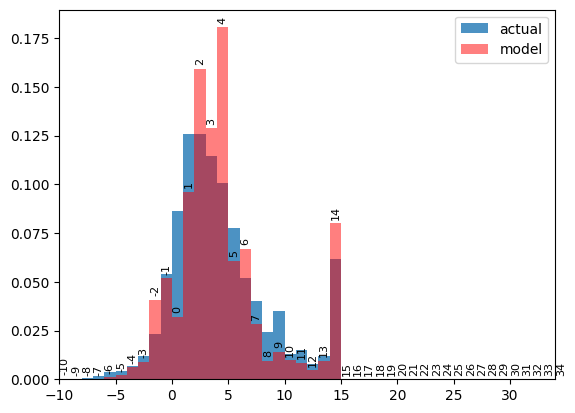

In [10]:
def get_ydl_chance(probs, ydl):

	cols = np.arange(probs.shape[1])
	mask = cols >= ydl[:, None]   # shape (3, 10), True where col >= start
	sums = (probs * mask).sum(axis=1).mean()
	return sums

def sample_model_yardline(yard, down):
	sample = rushes.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	probs = probs.mean(axis=0)
	

	plt.hist(y, range(-40,101),width=1, density=True, alpha=0.8, label='actual')

	actual_mean = y.mean()
	model_mean = (np.arange(len(probs)) - 40) @ probs
	print(f"Actual mean: {actual_mean:.2f}, Model mean: {model_mean:.2f}")
	print(f'number of datapoints: {len(inp)}')
	return probs

yard = 14
down = 2
probs = sample_model_yardline(yard, down)
plt.bar(range(-40, 100), probs, width=1, alpha=0.5, align="edge", label="model", color='r')
3
# Add index labels on top of bars
for i, p in enumerate(probs):
	yard_val = -40 + i
	if -10 <= yard_val <= yard + 20:  # only label visible range
		plt.text(yard_val + 0.5, p + 0.002, str(yard_val),
				 ha='center', va='bottom', fontsize=8, rotation=90)


plt.legend()
plt.xlim(-10,yard+20)

In [11]:
def sample_model_yardline(yard, down):
	sample = rushes#.loc[(rushes.yardline_100 == yard) & (rushes.down.between(1,1))].reset_index(drop=True)
	true_first = sample['first_down'].mean().item()
	true_td = sample['touchdown'].mean().item()
	print(f"{true_first=:.2f}, {true_td=:.2f}")
	inp =  sample[x_cols]
	y = sample['yards_gained']

	inp = torch.tensor(inp.values, dtype=torch.float32)
	out = rush_yards_model(inp).detach().numpy()
	exp_logits = np.exp(out - np.max(out, axis=1, keepdims=True))
	probs = exp_logits / exp_logits.sum(axis=1, keepdims=True)
	td_model = get_ydl_chance(probs, sample['yardline_100'].values + 40).item()
	fd_model = get_ydl_chance(probs, sample['ydstogo'].values + 40).item()
	print(f"{fd_model=:.2f}, {td_model=:.2f}")
	
	return probs

probs = sample_model_yardline(10,4)
probs

true_first=0.24, true_td=0.03
fd_model=0.22, td_model=0.03


array([[1.51332180e-12, 4.43811058e-13, 3.91651555e-12, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.63681090e-13, 1.09900594e-13, 4.63667028e-13, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [2.32915770e-16, 5.48064496e-17, 4.63820101e-16, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       ...,
       [2.39878137e-21, 3.72788148e-22, 6.16133476e-21, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [9.43772411e-15, 1.93855645e-15, 3.00321257e-14, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00],
       [3.68719434e-21, 5.67236227e-22, 1.04219789e-20, ...,
        0.00000000e+00, 0.00000000e+00, 0.00000000e+00]],
      shape=(269031, 140), dtype=float32)

In [12]:
rushes['pred'] = torch.sum(torch.tensor((probs * np.arange(-40,100))),dim=1)
rushes

,desc,game_id,yards_gained,yards_shifted,is_first_down,is_second_down,is_third_down,is_fourth_down,first_down,touchdown,...,name,game_id_1,gsis_id,yardline_100,ydstogo,down,goal_to_go,spread_line,total_line,pred
0,(3:03) 30-A.Green up the middle to DET 19 for ...,2001_01_DET_GB,1.0,41.0,1,0,0,0,0.0,0.0,...,Ahman Green,2001_01_DET_GB,00-0006305,20.0,10.0,1.0,0.0,5.5,41.5,3.097048
1,(:21) 4-B.Favre up the middle to DET 2 for -1 ...,2001_01_DET_GB,-1.0,39.0,0,0,0,1,0.0,0.0,...,Brett Favre,2001_01_DET_GB,00-0005106,1.0,1.0,4.0,1.0,5.5,41.5,-0.243188
2,(2:00) 10-C.Batch right end to GB 38 for 7 yar...,2001_01_DET_GB,7.0,47.0,0,1,0,0,0.0,0.0,...,Charlie Batch,2001_01_DET_GB,00-0000865,45.0,9.0,2.0,0.0,5.5,41.5,2.571716
3,(12:34) 5-D.McNabb right end to PHI 26 for 8 y...,2001_01_STL_PHI,8.0,48.0,0,1,0,0,0.0,0.0,...,Donovan McNabb,2001_01_STL_PHI,00-0011022,82.0,27.0,2.0,0.0,-3.0,46.0,5.964218
4,(1:05) 28-F.Taylor left tackle to PIT 16 for 2...,2001_01_PIT_JAX,24.0,64.0,0,1,0,0,1.0,0.0,...,Fred Taylor,2001_01_PIT_JAX,00-0016098,40.0,9.0,2.0,0.0,3.0,37.5,15.998671
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269026,(11:50) (Shotgun) 28-J.Taylor up the middle to...,2025_10_ATL_IND,4.0,44.0,0,1,0,0,0.0,0.0,...,Jonathan Taylor,2025_10_ATL_IND,00-0036223,31.0,6.0,2.0,0.0,6.5,48.5,1.790941
269027,(14:54) 4-J.Cook right end pushed ob at BUF 42...,2025_13_BUF_PIT,19.0,59.0,1,0,0,0,1.0,0.0,...,James Cook,2025_13_BUF_PIT,00-0037248,77.0,10.0,1.0,0.0,-3.0,44.5,17.332371
269028,(13:17) 5-R.Dowdle left guard to CAR 33 for 9 ...,2025_06_DAL_CAR,9.0,49.0,1,0,0,0,0.0,0.0,...,Rico Dowdle,2025_06_DAL_CAR,00-0036139,76.0,10.0,1.0,0.0,-3.0,47.5,3.030337
269029,(12:29) 28-J.Taylor left end to ATL 31 for 4 y...,2025_10_ATL_IND,4.0,44.0,1,0,0,0,0.0,0.0,...,Jonathan Taylor,2025_10_ATL_IND,00-0036223,35.0,10.0,1.0,0.0,6.5,48.5,3.173395


In [13]:
rushes['RYOE'] = rushes['yards_gained'] - rushes['pred']


In [14]:
ex = rushes.loc[rushes.season ==2025].groupby(['rusher_player_name', 'qb_scramble'])['RYOE'].mean().reset_index().sort_values(by='RYOE')
cnt = rushes.loc[rushes.season == 2025]['rusher_player_name'].value_counts().reset_index()
ex = ex.merge(cnt)
ex.loc[(ex['count'] > 40) & (ex.qb_scramble == 0)].sort_values(by='RYOE').tail(30)

,rusher_player_name,qb_scramble,RYOE,count
176,Z.Knight,0.0,0.227671,72
178,R.Stevenson,0.0,0.244560,99
179,J.Jacobs,0.0,0.265169,182
180,J.Warren,0.0,0.275908,148
182,C.Hubbard,0.0,0.293997,109
183,K.Hunt,0.0,0.302279,125
186,K.Gainwell,0.0,0.322028,72
189,J.Croskey-Merritt,0.0,0.359165,116
190,D.Montgomery,0.0,0.392984,120
193,D.Achane,0.0,0.400903,182


In [15]:
rushes.groupby('season')['RYOE'].mean()

season
2001    0.012940
2002    0.267158
2003    0.149305
2004    0.025254
2005    0.039454
2006    0.178763
2007    0.141029
2008    0.203902
2009    0.232695
2010    0.111866
2011    0.179334
2012    0.129063
2013    0.143726
2014    0.101513
2015    0.090658
2016    0.136332
2017    0.058675
2018    0.151349
2019    0.239462
2020    0.264979
2021    0.209641
2022    0.276531
2023    0.145787
2024    0.278870
2025    0.262976
Name: RYOE, dtype: float64

In [16]:
rushes.groupby(['qb_scramble'])[['yards_gained', 'RYOE']].mean()

,yards_gained,RYOE
qb_scramble,,
0.0,4.276657,0.149719
1.0,7.616711,0.804421


In [17]:
ex.loc[ex.rusher_player_name.str.contains('R.Dowdle')]

,rusher_player_name,qb_scramble,RYOE,count
196,R.Dowdle,0.0,0.41921,189


5.53


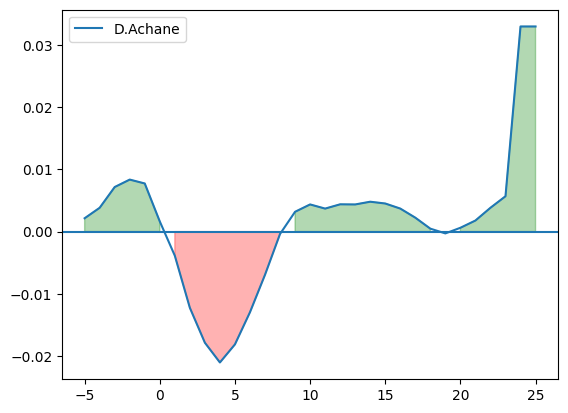

In [18]:
def vis_rusher(name):
	r1 = rushes.loc[
		(rushes.rusher_player_name == name) & (rushes.season == 2025), "yards_gained"
	]
	print(r1.mean().round(2))
	r1 = r1.apply(lambda x: max(-8,min(x, 25))).value_counts(normalize=True).reset_index()
	r_ = rushes.loc[
		(rushes.season >= 2023), "yards_gained"
	].apply(lambda x: max(-8,min(x, 25))).value_counts(normalize=True).reset_index()
	out = r1.merge(r_, on ='yards_gained', how='right')
	out['proportion_x'] = out['proportion_x'].fillna(0)
	out['di'] = (out['proportion_x'] - out['proportion_y']).fillna(0)
	out = out.sort_values(by='yards_gained')
	out['di'] = out['di'].rolling(5, min_periods=0, center=True).mean().rolling(3, min_periods=0, center=True).mean()
	out.loc[out.index[-1], 'di'] = out['proportion_x'].iloc[-1]
	out.loc[out.index[-2], 'di'] = out['proportion_x'].iloc[-1]
	out = out.loc[out.yards_gained > -6]
	plt.axhline(0)
	x = out['yards_gained']
	y = out['di']
	plt.plot(x,y, label=name)
	plt.fill_between(x, y, 0, where=(y>0), color='green', alpha=0.3)
	plt.fill_between(x, y, 0, where=(y<0), color='red', alpha=0.3)
	#plt.show()
	return out

out = vis_rusher('D.Achane')

#vis_rusher('C.McCaffrey')
plt.legend()

In [19]:
choices = rushes.loc[rushes.season==2025,'rusher_player_name'].value_counts().head(50).index.values

In [20]:
import ipywidgets as widgets
from IPython.display import display

# Create dropdown
dropdown = widgets.Dropdown(
    options=choices,
    value=choices[0],  # default value
    description='Choose:',
)


@widgets.interact(choice=choices)
def f(choice):
    vis_rusher(choice)


interactive(children=(Dropdown(description='choice', options=('B.Robinson', 'C.McCaffrey', 'J.Cook', 'J.Taylor…